In [489]:
#Import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.api import VAR, ARIMA

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA

from pylab import rcParams

## Feature Engineering

In [490]:
# Reading in saved dataframe from 1_EDA_DC_Covid.ipynb
tot_cases_per_ward_df = pd.read_csv('./Data/tot_cases_per_ward_df.csv')
net_new_daily_cases = pd.read_csv('./Data/net_new_daily_cases.csv')

# Setting Date index
tot_cases_per_ward_df['Date'] = pd.to_datetime(tot_cases_per_ward_df['Date'])
tot_cases_per_ward_df.set_index('Date', inplace=True)
tot_cases_per_ward_df.sort_index(inplace=True)

net_new_daily_cases['Date'] = pd.to_datetime(net_new_daily_cases['Date'])
net_new_daily_cases.set_index('Date', inplace=True)
net_new_daily_cases.sort_index(inplace=True)

net_new_daily_cases.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases
Date,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0


To obtain temperature data, I visited [Weather Underground](https://www.wunderground.com/history/daily/us/va/arlington-county/KDCA) and used panda's read_clipboard function to copy the tables for each month, as demonstrated below. 

In [462]:
# april_temp_stats = pd.read_clipboard()

In [463]:
# may_temp_stats = pd.read_clipboard()

In [464]:
# june_temp_stats = pd.read_clipboard()

In [465]:
# july_temp_stats = pd.read_clipboard()

In [466]:
# aug_temp_stats = pd.read_clipboard()

In [467]:
# sep_temp_stats = pd.read_clipboard()

In [468]:
# oct_temp_stats = pd.read_clipboard()

In [469]:
# nov_temp_stats = pd.read_clipboard()

In [470]:
# dec_temp_stats = pd.read_clipboard()

In [471]:
# jan_21_temp_stats = pd.read_clipboard()

In [472]:
# temp_months = [april_temp_stats, may_temp_stats, june_temp_stats, july_temp_stats, aug_temp_stats, sep_temp_stats,
#               oct_temp_stats, nov_temp_stats, dec_temp_stats, jan_21_temp_stats]
# temp_stats = pd.concat(temp_months, ignore_index=True)
# temp_stats.to_csv('./Data/temp_stats.csv', index=False)

In [496]:
temp_stats = pd.read_csv('./Data/temp_stats.csv')
temp_stats.index = net_new_daily_cases.index
temp_stats.drop(columns=['Max', 'Min'], inplace=True)
temp_stats.head()

,Avg
Date,
2020-04-01,47.6
2020-04-02,54.0
2020-04-03,56.8
2020-04-04,54.4
2020-04-05,57.1


In [497]:
engineered_df = pd.concat([net_new_daily_cases, temp_stats], axis=1)
engineered_df.rename(columns={'Avg':'Avg_Temp'}, inplace=True)

In [498]:
engineered_df.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases,Avg_Temp
Date,,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0,47.6
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0,54.0
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0,56.8
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0,54.4
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0,57.1


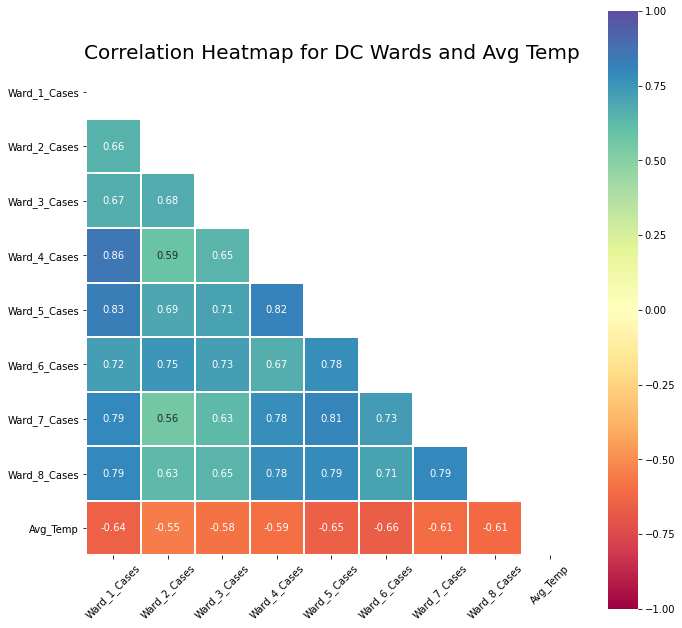

In [506]:
mask = np.zeros(engineered_df.corr().shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
plt.figure(figsize=(11, 11))
sns.heatmap(engineered_df.corr(), annot=True, 
            cmap='Spectral', vmin=-1, vmax=1, linewidths=1, square=True, mask=mask)
plt.title('Correlation Heatmap for DC Wards and Avg Temp', fontsize=20)
plt.xticks(rotation=45);

If you put function in a py file, you can call it from another notebook. Make a functions py file and then call in the functions from that file. 

In [509]:
for i in range(1, 9):
        
    engineered_df[f'Ward_{i}_Cases_2M_Avg'] = engineered_df[f'Ward_{i}_Cases'].rolling(60).mean()
    
    engineered_df[f'Ward_{i}_Cases_1M_Avg'] = engineered_df[f'Ward_{i}_Cases'].rolling(30).mean()
    
engineered_df.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases,Avg_Temp,Ward_1_Cases_2M_Avg,...,Ward_4_Cases_2M_Avg,Ward_4_Cases_1M_Avg,Ward_5_Cases_2M_Avg,Ward_5_Cases_1M_Avg,Ward_6_Cases_2M_Avg,Ward_6_Cases_1M_Avg,Ward_7_Cases_2M_Avg,Ward_7_Cases_1M_Avg,Ward_8_Cases_2M_Avg,Ward_8_Cases_1M_Avg
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0,47.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0,54.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0,56.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0,54.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0,57.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [510]:
# Making two new columns per Ward of the case data shifted forward by 24 and 48 hours, respectively

for i in range(1, 9):
    
    engineered_df[f'Ward_{i}_Cases'] = engineered_df[f'Ward_{i}_Cases']
    
    engineered_df[f'Ward_{i}_Cases_Shift_M'] = engineered_df[f'Ward_{i}_Cases'].shift(30)
    
    engineered_df[f'Ward_{i}_Cases_Shift_2W'] = engineered_df[f'Ward_{i}_Cases'].shift(14)
        
engineered_df.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases,Avg_Temp,Ward_1_Cases_2M_Avg,...,Ward_4_Cases_Shift_M,Ward_4_Cases_Shift_2W,Ward_5_Cases_Shift_M,Ward_5_Cases_Shift_2W,Ward_6_Cases_Shift_M,Ward_6_Cases_Shift_2W,Ward_7_Cases_Shift_M,Ward_7_Cases_Shift_2W,Ward_8_Cases_Shift_M,Ward_8_Cases_Shift_2W
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0,47.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0,54.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0,56.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0,54.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0,57.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [517]:
def visualize_data(df, cols, title=None, x_label=None, y_label=None, spacing = 50):
    
    plt.figure(figsize=(12,7))
    legend = []
    
    for col in cols:
            
        plt.plot(df[col])
        legend.append(col)
        
    # Listing legend items in visualization
    plt.legend(legend)
    
    # Set tick marks
    plt.yticks(fontsize=15)
    plt.xticks(df.index[0::spacing], fontsize=12)
    
    # Set title and labels
    plt.title(title, fontsize=20)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16);

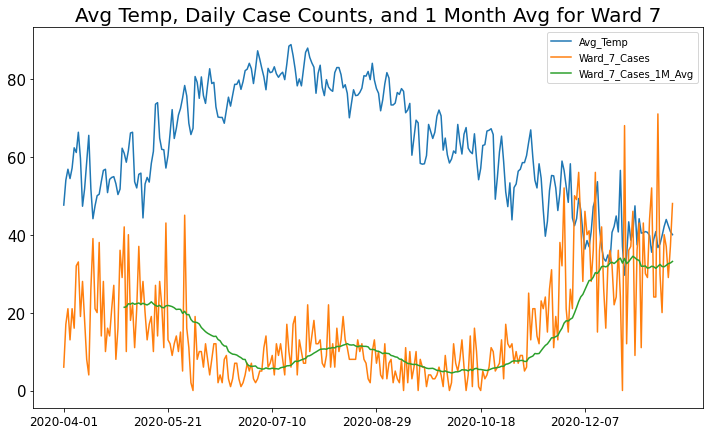

In [518]:
visualize_data(engineered_df, ['Avg_Temp', 'Ward_7_Cases', 'Ward_7_Cases_1M_Avg'], 
               title='Avg Temp, Daily Case Counts, and 1 Month Avg for Ward 7')

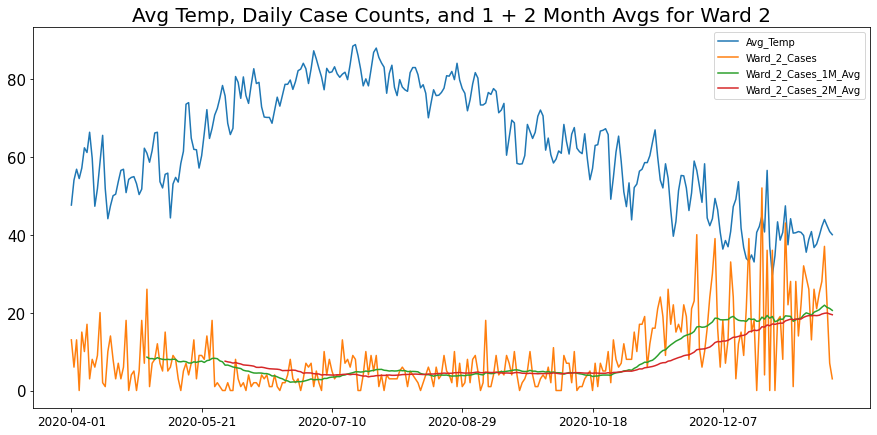

In [513]:
visualize_data(engineered_df, ['Avg_Temp', 'Ward_2_Cases', 'Ward_2_Cases_1M_Avg', 'Ward_2_Cases_2M_Avg'], 
               'Avg Temp, Daily Case Counts, and 1 + 2 Month Avgs for Ward 2')

In [483]:
engineered_df.columns

Index(['Ward_1_Cases', 'Ward_2_Cases', 'Ward_3_Cases', 'Ward_4_Cases',
       'Ward_5_Cases', 'Ward_6_Cases', 'Ward_7_Cases', 'Ward_8_Cases',
       'Max_Temp', 'Avg_Temp', 'Min_Temp', 'Ward_1_Cases_2M_Avg',
       'Ward_1_Cases_1M_Avg', 'Ward_2_Cases_2M_Avg', 'Ward_2_Cases_1M_Avg',
       'Ward_3_Cases_2M_Avg', 'Ward_3_Cases_1M_Avg', 'Ward_4_Cases_2M_Avg',
       'Ward_4_Cases_1M_Avg', 'Ward_5_Cases_2M_Avg', 'Ward_5_Cases_1M_Avg',
       'Ward_6_Cases_2M_Avg', 'Ward_6_Cases_1M_Avg', 'Ward_7_Cases_2M_Avg',
       'Ward_7_Cases_1M_Avg', 'Ward_8_Cases_2M_Avg', 'Ward_8_Cases_1M_Avg',
       'Ward_1_Cases_Shift_M', 'Ward_1_Cases_Shift_2W', 'Ward_2_Cases_Shift_M',
       'Ward_2_Cases_Shift_2W', 'Ward_3_Cases_Shift_M',
       'Ward_3_Cases_Shift_2W', 'Ward_4_Cases_Shift_M',
       'Ward_4_Cases_Shift_2W', 'Ward_5_Cases_Shift_M',
       'Ward_5_Cases_Shift_2W', 'Ward_6_Cases_Shift_M',
       'Ward_6_Cases_Shift_2W', 'Ward_7_Cases_Shift_M',
       'Ward_7_Cases_Shift_2W', 'Ward_8_Cases_Shift_

In [484]:
engineered_df.to_csv('./Data/engineered_df.csv')

In [485]:
engineered_df.describe()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases,Max_Temp,Avg_Temp,...,Ward_4_Cases_Shift_M,Ward_4_Cases_Shift_2W,Ward_5_Cases_Shift_M,Ward_5_Cases_Shift_2W,Ward_6_Cases_Shift_M,Ward_6_Cases_Shift_2W,Ward_7_Cases_Shift_M,Ward_7_Cases_Shift_2W,Ward_8_Cases_Shift_M,Ward_8_Cases_Shift_2W
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,...,263.000000,279.000000,263.000000,279.000000,263.000000,279.000000,263.000000,279.000000,263.000000,279.000000
mean,14.296928,8.795222,6.180887,18.911263,17.518771,14.614334,15.791809,16.215017,71.255973,63.105119,...,16.817490,17.677419,15.174905,16.182796,11.965779,12.982079,13.813688,14.738351,13.942966,15.146953
std,11.708674,8.979755,6.243192,15.430100,14.171304,14.360264,13.355300,14.104970,15.520402,14.752697,...,13.757335,14.418335,11.555038,12.769072,11.234946,12.198141,11.542796,12.464323,12.089700,13.280994
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,29.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,2.000000,8.000000,7.000000,5.000000,6.000000,6.000000,59.000000,52.100000,...,7.000000,8.000000,7.000000,7.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000
50%,10.000000,6.000000,4.000000,13.000000,13.000000,8.000000,12.000000,11.000000,72.000000,63.100000,...,12.000000,12.000000,12.000000,13.000000,8.000000,8.000000,10.000000,11.000000,11.000000,11.000000
75%,21.000000,12.000000,8.000000,28.000000,23.000000,19.000000,21.000000,23.000000,85.000000,76.800000,...,22.500000,24.500000,20.000000,21.000000,15.000000,17.000000,18.500000,20.500000,17.000000,20.000000
max,63.000000,52.000000,35.000000,80.000000,90.000000,76.000000,71.000000,75.000000,99.000000,88.800000,...,75.000000,80.000000,63.000000,90.000000,57.000000,57.000000,56.000000,68.000000,69.000000,75.000000


## Standard Scaler

In [486]:
model_df = engineered_df[['Ward_1_Cases',
       'Ward_2_Cases', 'Ward_3_Cases', 'Ward_4_Cases',
       'Ward_5_Cases', 'Ward_6_Cases', 'Ward_7_Cases',
       'Ward_8_Cases', 'Avg_Temp']]

In [487]:
model_df.to_csv('./Data/model_df.csv')

In [423]:
ss = StandardScaler()
ss = ss.fit(model_df)

In [424]:
model_df_sc = ss.transform(model_df)

In [425]:
scaled_cols = ['Ward_1_Scaled', 'Ward_2_Scaled', 'Ward_3_Scaled', 'Ward_4_Scaled', 'Ward_5_Scaled',
              'Ward_6_Scaled', 'Ward_7_Scaled', 'Ward_8_Scaled', 'Avg_Temp_Scaled']

In [426]:
model_df_sc = pd.DataFrame(model_df_sc, columns=scaled_cols, index=model_df.index)
model_df_sc.head()

,Ward_1_Scaled,Ward_2_Scaled,Ward_3_Scaled,Ward_4_Scaled,Ward_5_Scaled,Ward_6_Scaled,Ward_7_Scaled,Ward_8_Scaled,Avg_Temp_Scaled
Date,,,,,,,,,
2020-04-01,-0.367615,0.469052,-0.510369,-0.513593,-0.743528,-0.252121,-0.734432,-0.654435,-1.052801
2020-04-02,-0.453168,-0.311813,-0.349920,-0.448674,-0.178042,0.236170,0.090620,-0.654435,-0.618239
2020-04-03,0.145703,0.469052,-0.670817,0.525115,0.458131,0.654704,0.390639,0.126766,-0.428119
2020-04-04,-0.624273,-0.981126,-0.349920,-0.578513,-0.955586,-0.879922,-0.209399,0.623894,-0.591079
2020-04-05,-0.196509,0.692156,-0.029023,0.265438,-0.531471,1.142994,0.390639,-0.654435,-0.407749


In [427]:
model_df_sc.describe()

,Ward_1_Scaled,Ward_2_Scaled,Ward_3_Scaled,Ward_4_Scaled,Ward_5_Scaled,Ward_6_Scaled,Ward_7_Scaled,Ward_8_Scaled,Avg_Temp_Scaled
count,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02
mean,-1.212530e-17,7.881447e-17,-3.228362e-16,-3.486025e-17,-1.458825e-16,-4.774338e-16,1.333783e-16,-8.677170e-17,-1.109465e-15
std,1.001711e+00,1.001711e+00,1.001711e+00,1.001711e+00,1.001711e+00,1.001711e+00,1.001711e+00,1.001711e+00,1.001711e+00
min,-1.223144e+00,-9.811258e-01,-9.917142e-01,-1.227705e+00,-1.238330e+00,-1.019434e+00,-1.184461e+00,-1.151563e+00,-2.275004e+00
25%,-7.953791e-01,-6.464694e-01,-6.708172e-01,-7.083512e-01,-7.435285e-01,-6.706550e-01,-7.344321e-01,-7.254530e-01,-7.472497e-01
50%,-3.676146e-01,-3.118130e-01,-3.499202e-01,-3.837549e-01,-3.194133e-01,-4.613878e-01,-2.844037e-01,-3.703616e-01,-3.476119e-04
75%,5.734672e-01,3.574998e-01,2.918739e-01,5.900342e-01,3.874454e-01,3.059253e-01,3.906390e-01,4.818579e-01,9.298849e-01
max,4.166689e+00,4.819585e+00,4.623984e+00,3.965836e+00,5.123398e+00,4.282003e+00,4.140876e+00,4.174809e+00,1.744687e+00


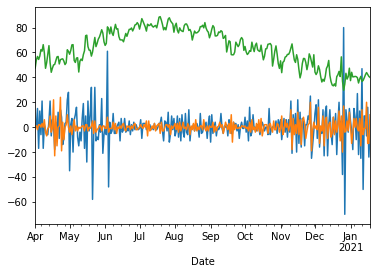

In [430]:
engineered_df['Ward_4_Cases'].diff().dropna().plot()
engineered_df['Ward_3_Cases'].diff().dropna().plot()
engineered_df['Avg_Temp'].plot();

In [432]:
model_df_sc.columns

Index(['Ward_1_Scaled', 'Ward_2_Scaled', 'Ward_3_Scaled', 'Ward_4_Scaled',
       'Ward_5_Scaled', 'Ward_6_Scaled', 'Ward_7_Scaled', 'Ward_8_Scaled',
       'Avg_Temp_Scaled'],
      dtype='object')

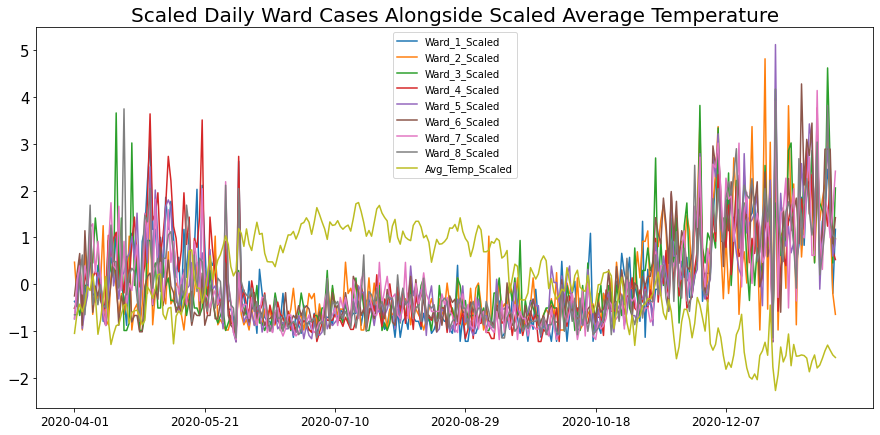

In [436]:
# One can see from the graph that as standardized temperature increases, the standardized daily Covid case
# rate tends to decrease.

visualize_data(model_df_sc, ['Ward_1_Scaled', 'Ward_2_Scaled', 'Ward_3_Scaled', 'Ward_4_Scaled',
       'Ward_5_Scaled', 'Ward_6_Scaled', 'Ward_7_Scaled', 'Ward_8_Scaled',
       'Avg_Temp_Scaled'], title='Scaled Daily Ward Cases Alongside Scaled Average Temperature')

In [442]:
model_df_sc.to_csv('./Data/model_df_sc.csv')

## Augmented Dickey Fuller Test

In [443]:
# Function infers whether data is stationary according to the p-value extracted from 
# Augmented Dickey Fuller test.

def get_p_value_adfuller(df, alpha=0.05):
    
    for col in df.columns:
        
        dftest = adfuller(df[col])
    
        if dftest[1] >= alpha:
            print(f'p-value for {col} is {dftest[1]} (greater than alpha {alpha}). Infer data is not stationary.\n')
           
        else:
            print(f'p-value for {col} is {dftest[1]} (smaller than alpha {alpha}). Infer data is stationary.\n')

In [444]:
get_p_value_adfuller(model_df_sc)

p-value for Ward_1_Scaled is 0.7377726355910978 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_2_Scaled is 0.8803395192028715 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_3_Scaled is 0.9783440609162204 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_4_Scaled is 0.7039304479629617 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_5_Scaled is 0.5383978060792187 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_6_Scaled is 0.9820970708777005 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_7_Scaled is 0.8834473281257176 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_8_Scaled is 0.9055492910659664 (greater than alpha 0.05). Infer data is not stationary.

p-value for Avg_Temp_Scaled is 0.9320838184316185 (greater than alpha 0.05). Infer data is not stationary.



In [445]:
# The ADF test results infer that differencing the dataframe once makes all variables stationary. 
get_p_value_adfuller(model_df_sc.diff().dropna())

p-value for Ward_1_Scaled is 1.1418968835084713e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_2_Scaled is 2.043551751652239e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_3_Scaled is 3.687967736949315e-07 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_4_Scaled is 1.8899110384489655e-25 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_5_Scaled is 6.251562744454237e-22 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_6_Scaled is 7.417860818263338e-11 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_7_Scaled is 5.156062722159832e-12 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_8_Scaled is 0.0016383842566225124 (smaller than alpha 0.05). Infer data is stationary.

p-value for Avg_Temp_Scaled is 2.7878450527608447e-13 (smaller than alpha 0.05). Infer data is stationary.



In [580]:
# inversed = ss.inverse_transform(model_df_sc)
# inversed

In [581]:
# from statsmodels.tsa.stattools import grangercausalitytests

# def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=False):    

#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=verbose)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# granger_matrix = grangers_causation_matrix(pd.DataFrame(model_df_sc, columns=model_df.columns), variables = model_df.columns)

In [582]:
# granger_matrix.head()